# Rebar Detection and Counting using YOLOv9
### [Xin Yao](https://xinyaoict.github.io/) 

This is a notebook that implements rebar detection and counting using YOLOv9, which is the newest state-of-the-art object detection model published very recently.

The link for the original code is: https://github.com/WongKinYiu/yolov9
The paper for YOLOv9 is at https://arxiv.org/abs/2402.13616

### 1. Download YOLOv9 from Github and install required packages

In [1]:
!git clone git@github.com:WongKinYiu/yolov9.git # or https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 167 (delta 29), reused 16 (delta 16), pack-reused 127
Receiving objects: 100% (167/167), 616.21 KiB | 457.00 KiB/s, done.
Resolving deltas: 100% (69/69), done.
/home/xinyao/yolov9


/home/xinyao/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install Pillow==9.5.0 # Install pillow with this version to avoid a warning later

In [3]:
import os
HOME = os.getcwd() # define a home directory

Download the pretrained models

In [4]:
!mkdir -p {HOME}/weights

!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

### 2. Download the Rebar dataset

In [5]:
!pip install gdown # install gdown to download files from Google Drive

In [6]:
!gdown 1-rRbIP2ds0zSjcI8j8o1ERm3ethAAiZr -O RebarDSC.zip
!unzip -q RebarDSC.zip -d RebarDSC
!rm RebarDSC.zip

Downloading...
From (original): https://drive.google.com/uc?id=1-rRbIP2ds0zSjcI8j8o1ERm3ethAAiZr
From (redirected): https://drive.google.com/uc?id=1-rRbIP2ds0zSjcI8j8o1ERm3ethAAiZr&confirm=t&uuid=72886114-3401-4ba6-b5a2-3720509b07cb
To: /home/xinyao/yolov9/RebarDSC.zip
100%|██████████████████████████████████████| 1.69G/1.69G [01:29<00:00, 18.8MB/s]


### 3. Convert the Rebar dataset to YOLO format

This is the key step to train YOLO on a new dataset. I converted the rebar dataset to align it with the formats used in YOLO.

In [7]:
import numpy as np
import cv2
import os
import csv
from collections import defaultdict
import shutil

data_folder_old = 'RebarDSC'

path_train = os.path.join(data_folder_old, 'annotations/100_percent_train.csv')
path_test = os.path.join(data_folder_old, 'annotations/test.csv')

dict_train = defaultdict(list)
dict_test = defaultdict(list)

with open(path_train, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        image_path = row[0]
        x1, y1, x2, y2  = row[1].split()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        dict_train[image_path].append([x1, y1, x2, y2])
# get 1125 images for training

with open(path_test, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        image_path = row[0]
        x1, y1, x2, y2  = row[1].split()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        dict_test[image_path].append([x1, y1, x2, y2])
# get 1000 images for testing

datafolder_new = 'rebar_data'

for phase in ['train', 'test']:
    phase_folder = os.path.join(datafolder_new, phase)
    img_folder = os.path.join(phase_folder, 'images')
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)
    label_folder = os.path.join(phase_folder, 'labels')
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)

    dict_data = dict_train if phase == 'train' else dict_test
    
    for image_path in dict_data.keys():
        new_image_path = os.path.join(img_folder, image_path)
        os.rename(os.path.join(data_folder_old, 'images',image_path), new_image_path)

        img = cv2.imread(new_image_path)
        height, width, _ = img.shape
        bounding_box_list = dict_data[image_path]
        for bounding_box in bounding_box_list:
            x1, y1, x2, y2 = bounding_box
            x_center = (x1 + x2) / 2
            y_center = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1
            x_center = x_center / width
            y_center = y_center / height
            w = w / width
            h = h / height
            with open(os.path.join(label_folder, image_path.replace('.jpg', '.txt')), 'a') as f:
                f.write('0 %f %f %f %f\n' % (x_center, y_center, w, h))
shutil.rmtree(data_folder_old)

Besides, we should include a `data.yaml` file that tells YOLO what classes are included in the dataset and where the train/val/test data are:

In [8]:
%%file rebar_data/data.yaml
names:
- rebar
nc: 1
rebar:
  project: rebar-detection
test: rebar_data/test/images
train: rebar_data/train/images
val: rebar_data/test/images

Writing rebar_data/data.yaml


## 4. Train the model using our own dataset and the pretrained weights

Now we can train our model using the pretrained models. Here I used the new proposed lightweight network GELAN (Generalized Efficient Layer Aggregation Network) in the YOLOv9 project as an example.

Due to GPU storage limitation, I set batch size as 2. 

In [9]:
!python train.py \
        --batch 2 --epochs 20 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
        --data rebar_data/data.yaml \
        --weights weights/gelan-c.pt \
        --cfg models/detect/gelan-c.yaml \
        --hyp hyp.scratch-high.yaml

train: weights=weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=rebar_data/data.yaml, hyp=hyp.scratch-high.yaml, epochs=20, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 v0.1-10-g33fc75e Python-3.9.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11976MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, cls_pw=1.0, dfl=1.5, obj_pw=1.0, iou_t=0.2, anchor_t=5.0,

## 5. Examine training results

Now we can examine the training results by showing the plotted training/validation loss and metrics during training.

In [10]:
from IPython.display import Image

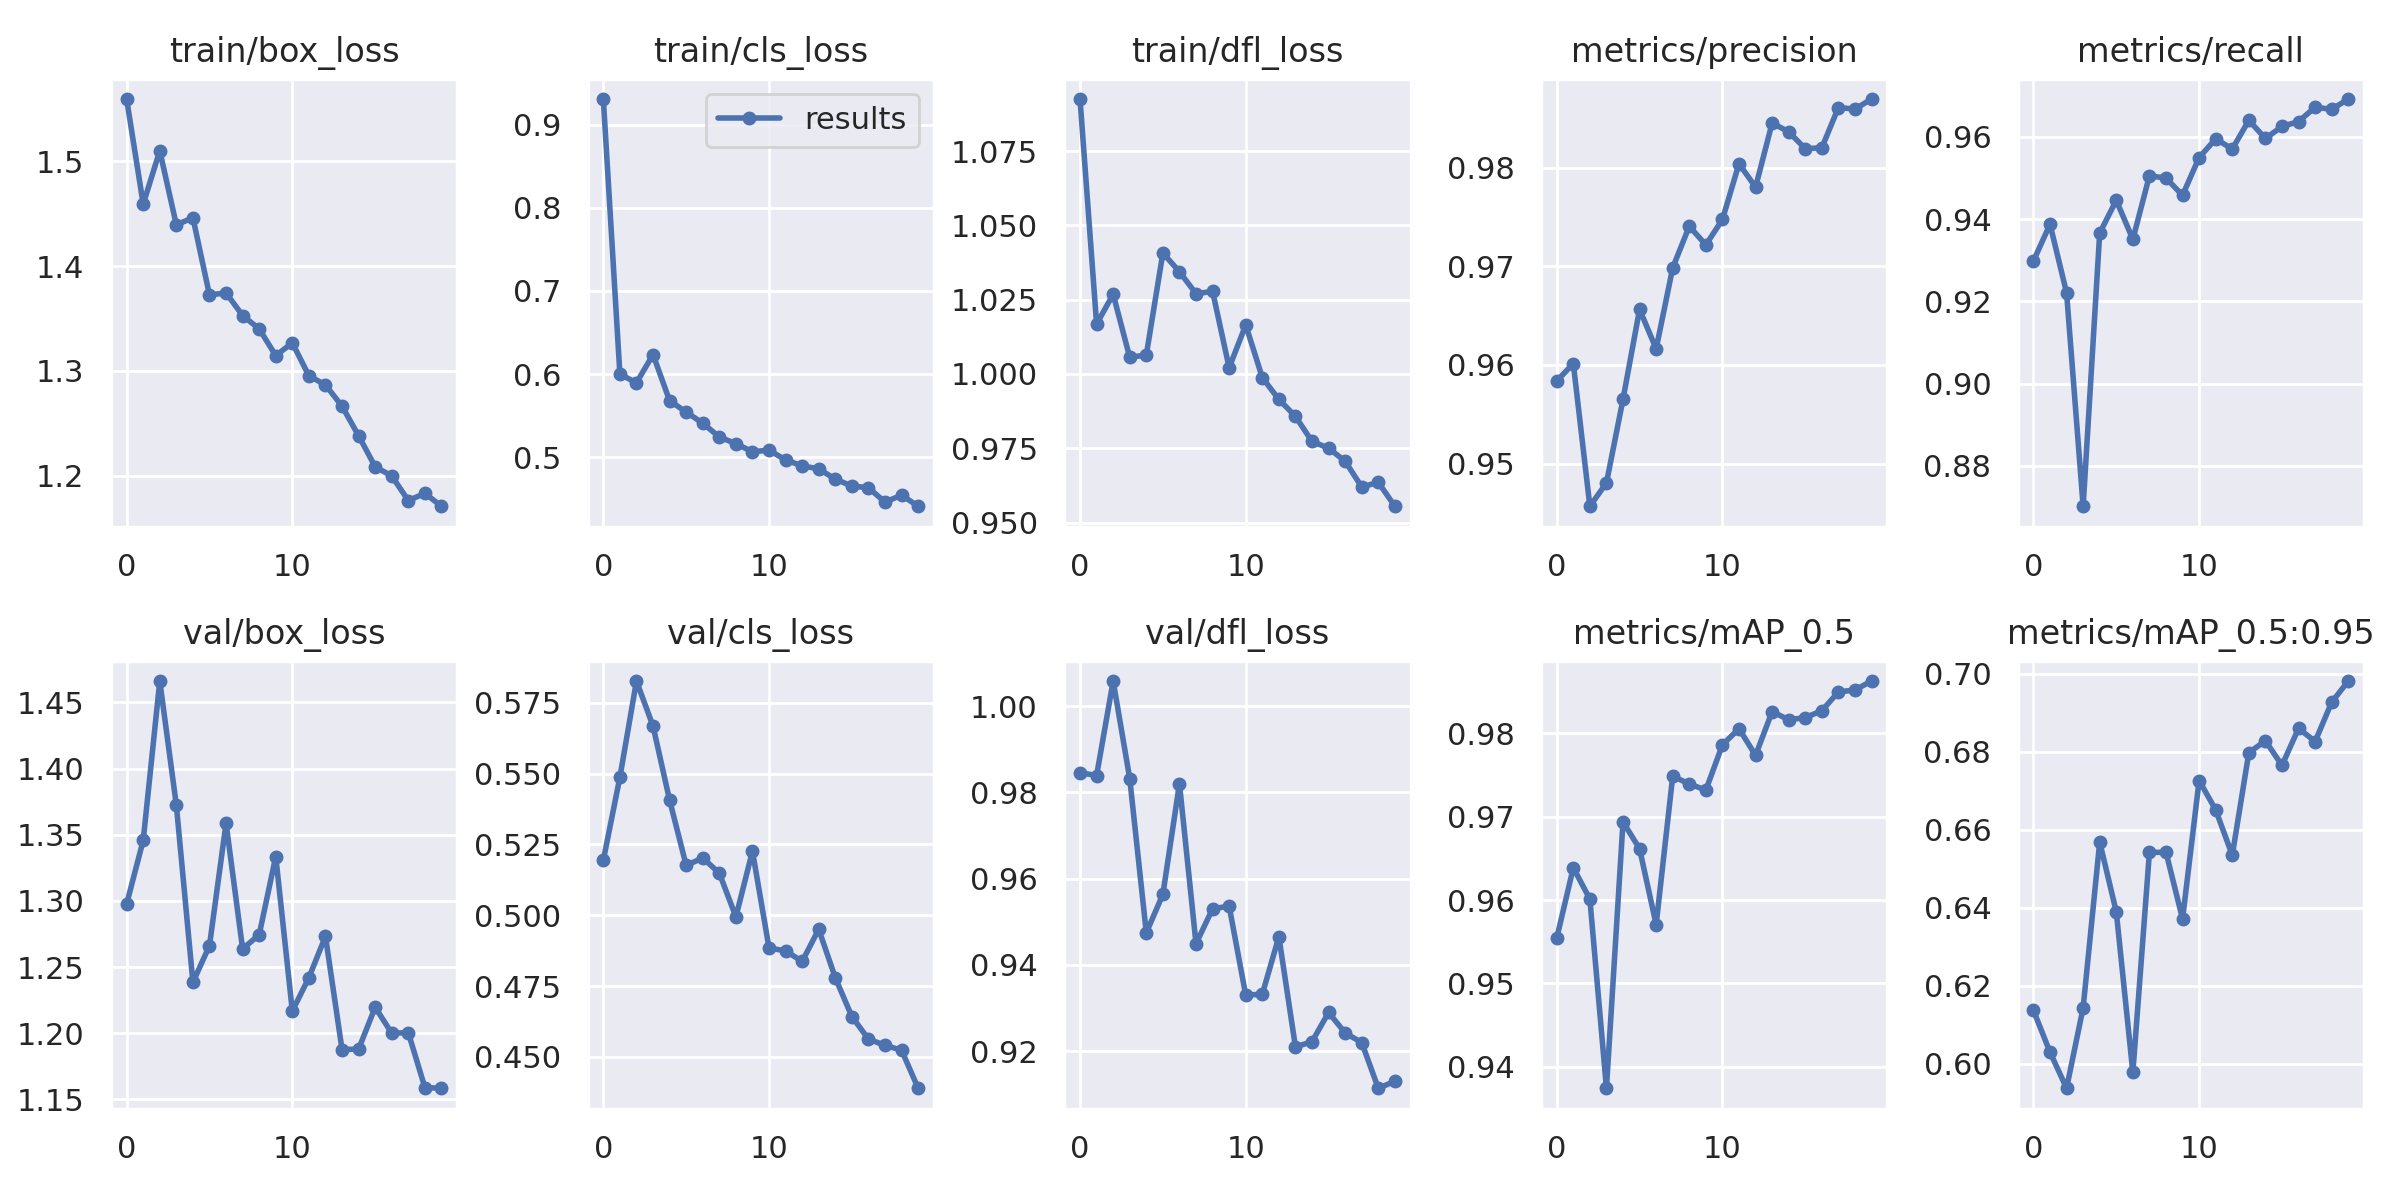

In [11]:
Image(filename=f"{HOME}/runs/train/exp/results.png", width=1000)

## 6. Testing the new YOLOv9 model on the Rebar testset

Now let's get the results of the Rebar testset!

I modified some codes in `detect.py` to better visualize the results and calculate the counting accuracy. 

Please directly download from Google Drive and overwrite the original `detect.py`.

In [12]:
! gdown 1-xbhirSLrIvFGxnJS0G8TngJy872CIFU

Downloading...
From (original): https://drive.google.com/uc?id=1-xbhirSLrIvFGxnJS0G8TngJy872CIFU
From (redirected): https://drive.google.com/uc?id=1-xbhirSLrIvFGxnJS0G8TngJy872CIFU&confirm=t&uuid=c77285bd-8741-4185-970b-4f631dc1ab8f
To: /home/xinyao/yolov9/detect.py
100%|██████████████████████████████████████| 13.7k/13.7k [00:00<00:00, 14.5MB/s]


Run let's run the new `detect.py` file to get all the results. 

Please remember to set the experiment ID, corresponding to the training procedure above, in `--weights runs/train/<expID>/weights/best.pt`.

After running through all the 1000 test images. You should be able to get an accuracy around 98%. 

In [13]:
!python detect.py \
	--img 640 --conf-thres 0.5 --device 0 \
	--weights runs/train/exp/weights/best.pt \
	--source rebar_data/test/images\
	--line-thickness 2 \
	--hide-labels \
	--save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=rebar_data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=2, hide_labels=True, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v0.1-10-g33fc75e Python-3.9.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11976MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
image 1/1000 /home/xinyao/yolov9/rebar_data/test/images/rebar_1000_10MM.jpg: 640x480 349 rebars, 65.9ms
Predicted number of rebars: 349
Ground truth number of rebars: 358
image 2/1000 /home/xinyao/yolov9/rebar_data/test/images/rebar_1001_16MM.jpg: 640x480 138 rebars, 6.3ms
Predicted number of rebars: 138
Ground truth number

## 7. Visualize the test results

Now we can visualize some predicted images to understand how the result looks.

Please note the `expID` in `/runs/detect/expID/*.jpg'` is not necessarily the same as the ID number used in training. Set the correct one created in the testing procedure.


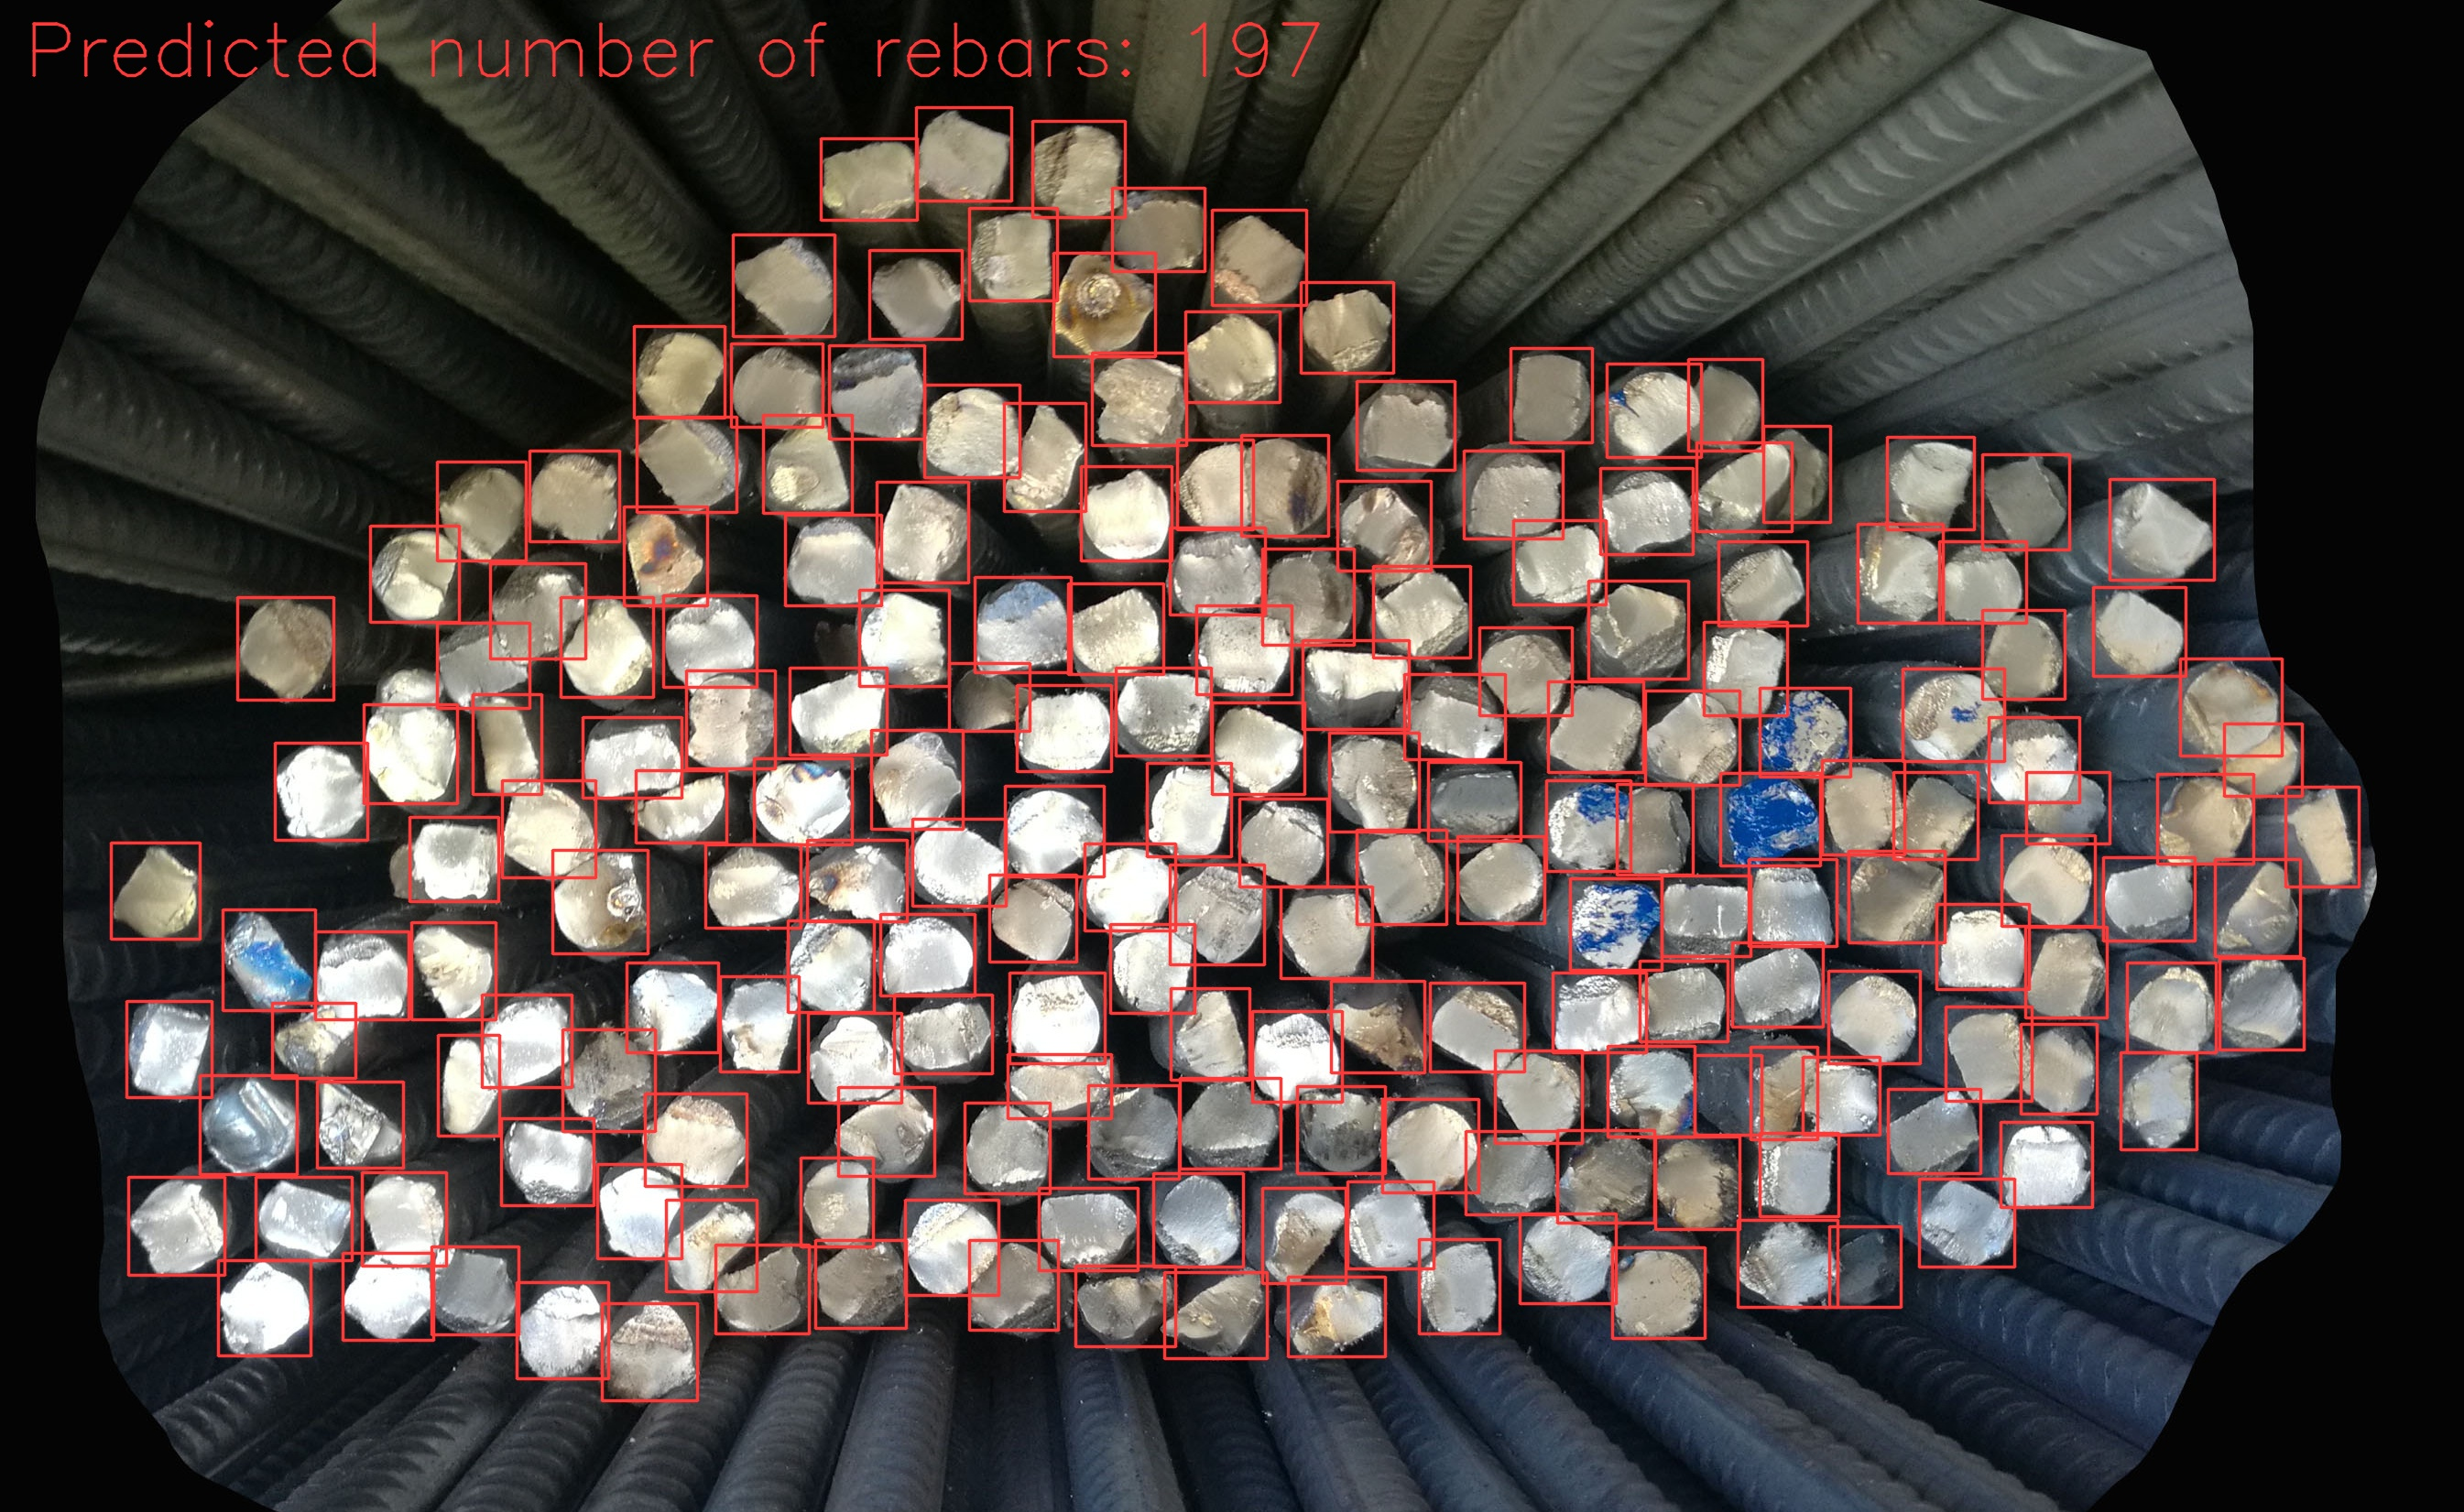

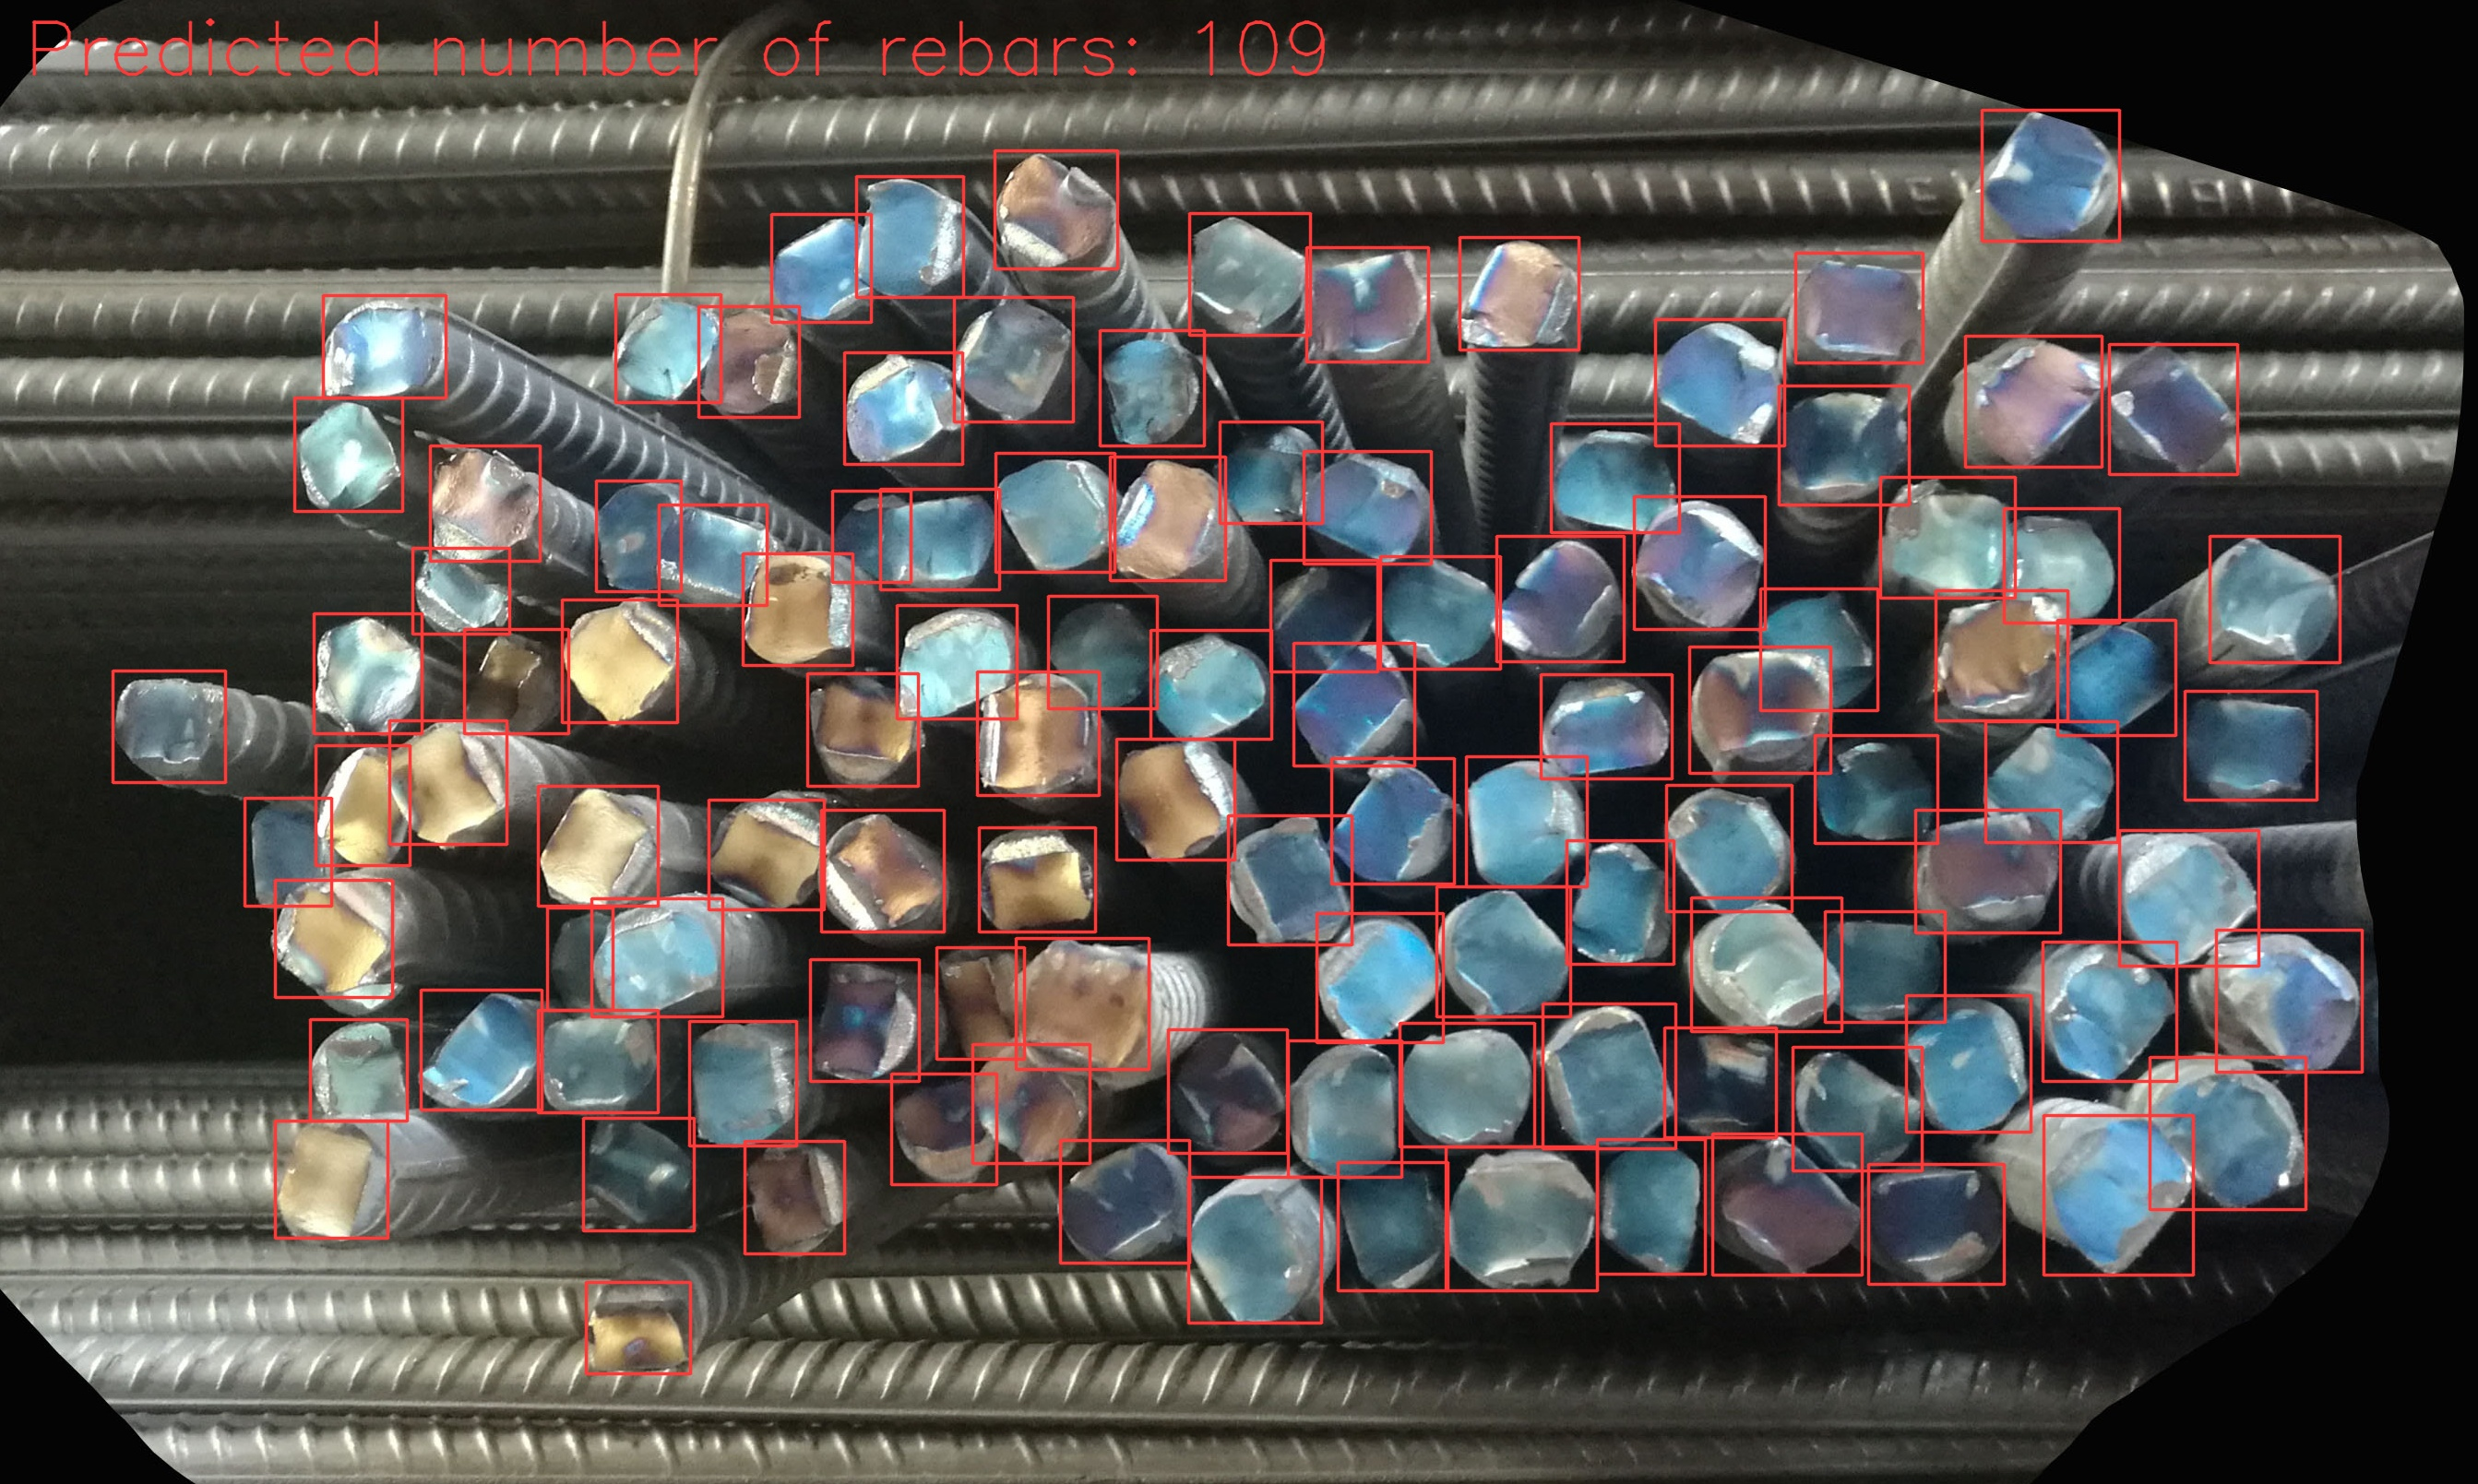

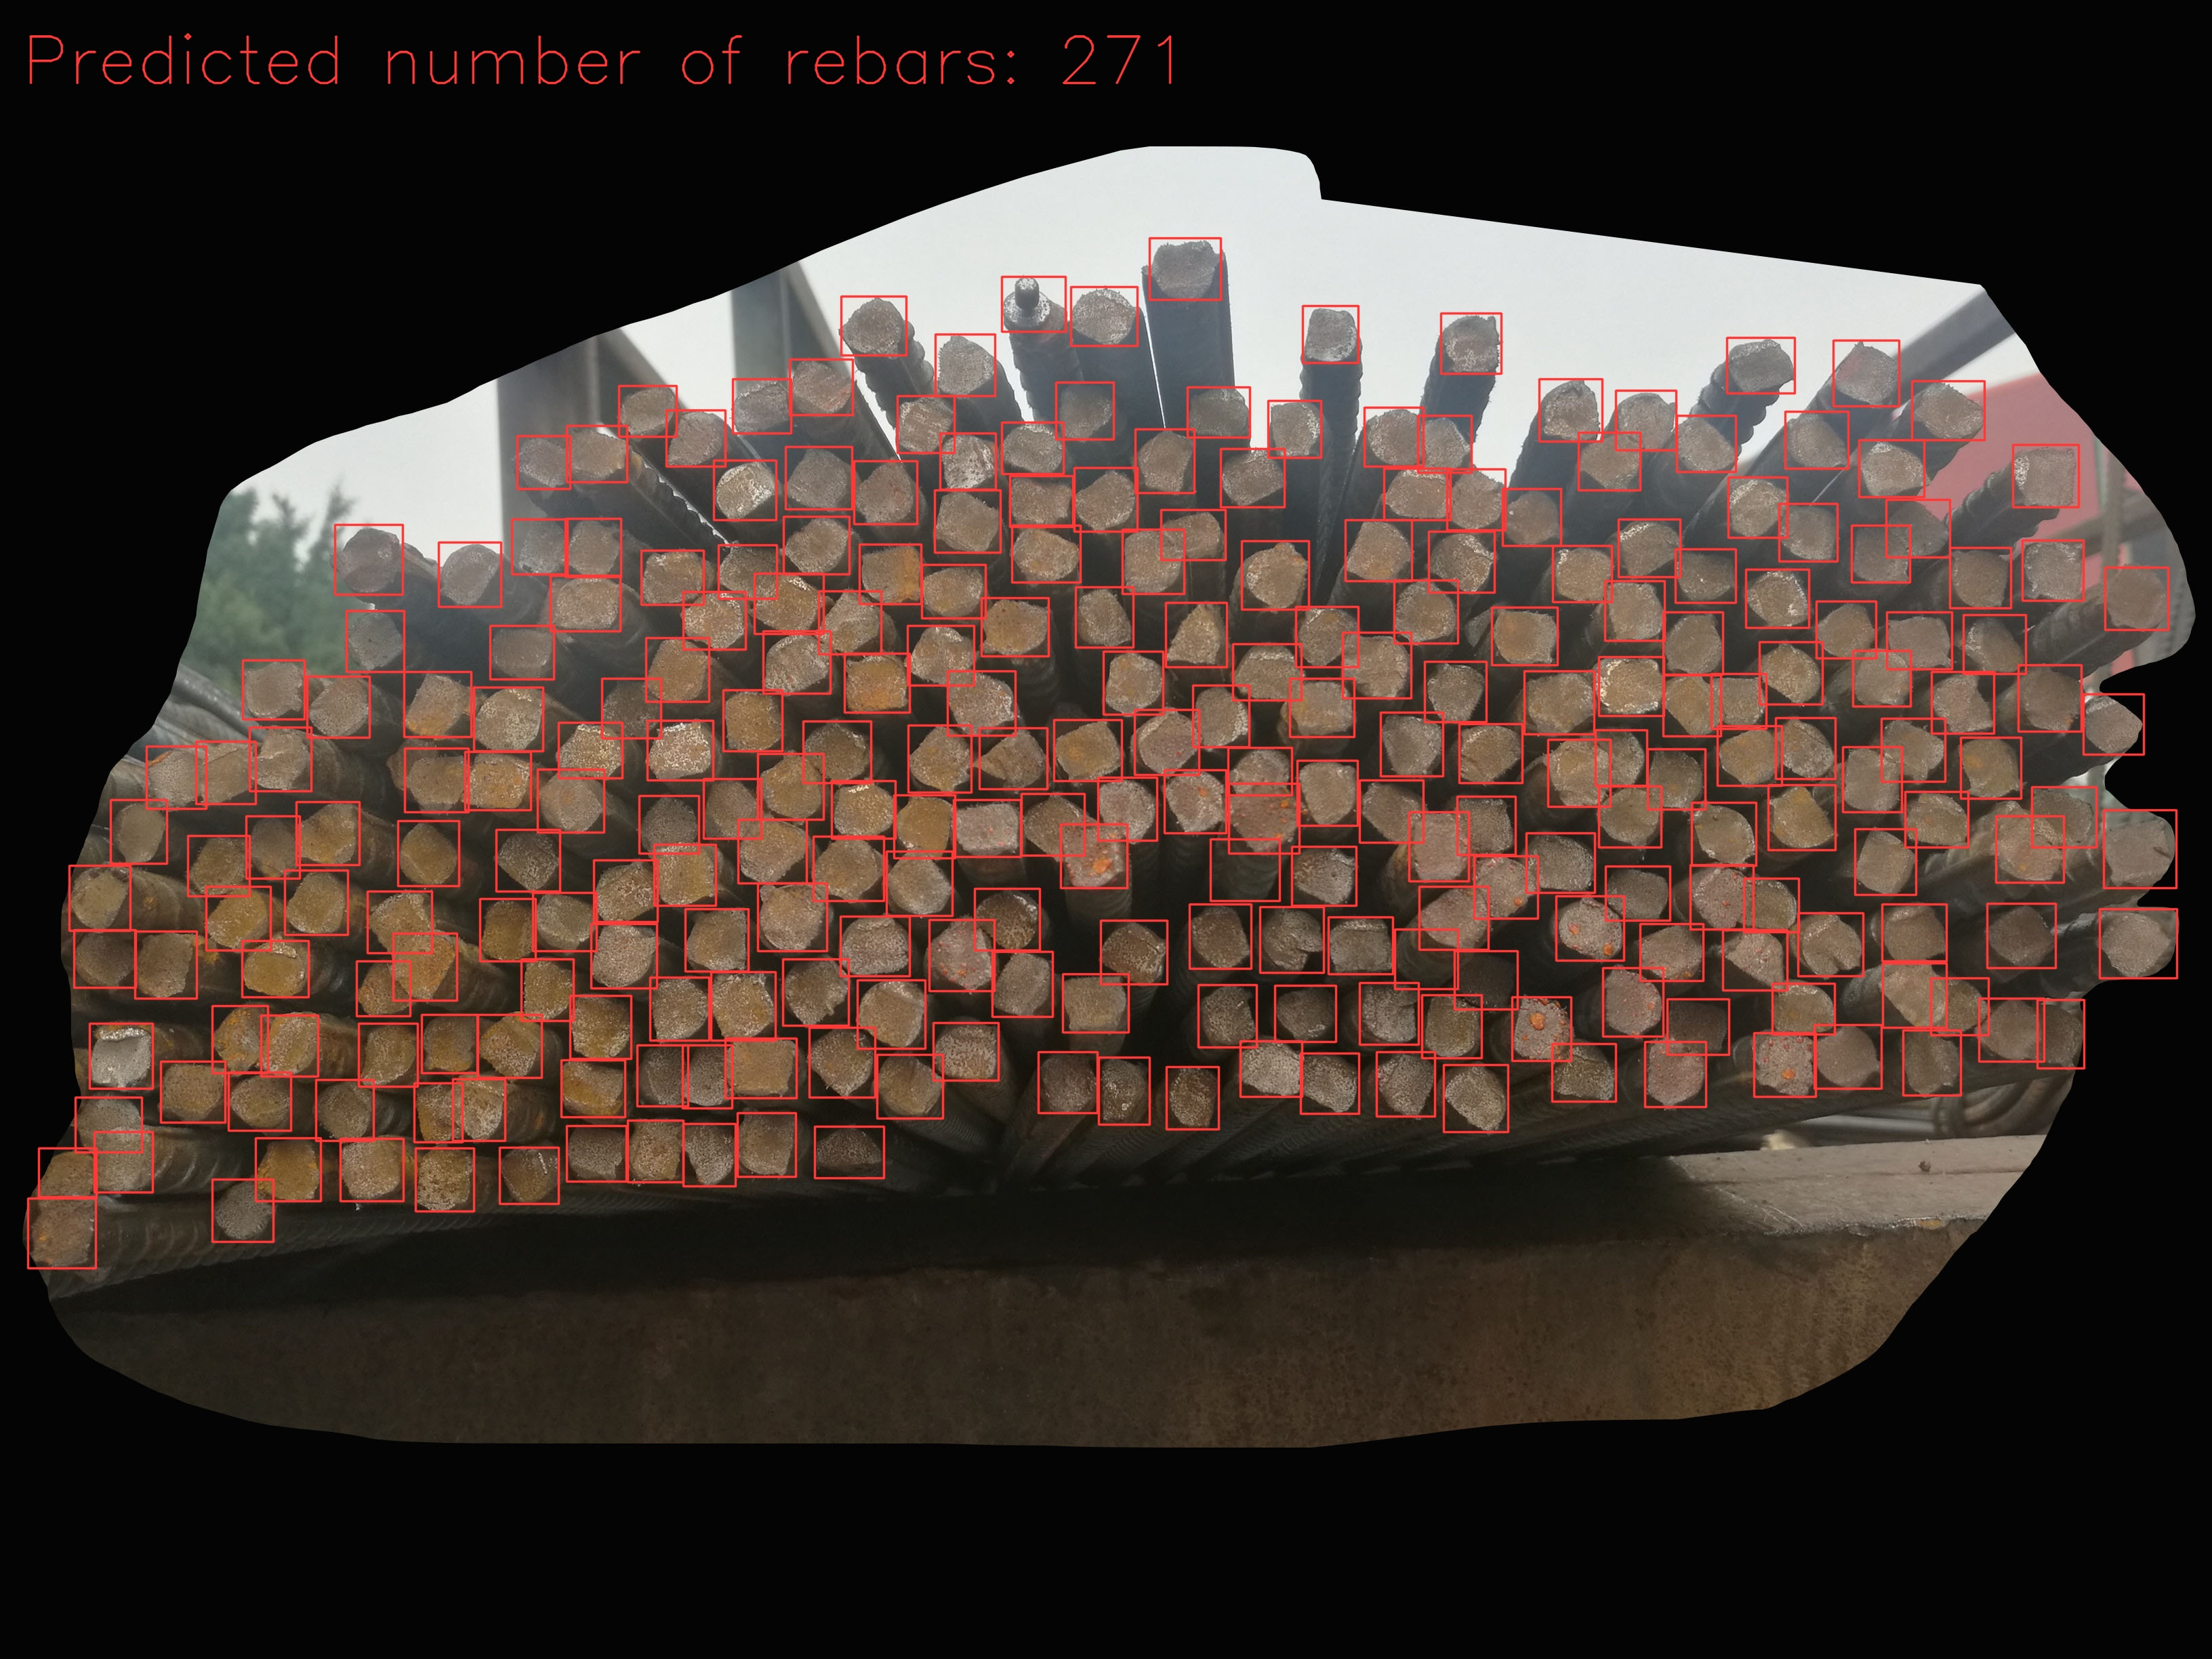

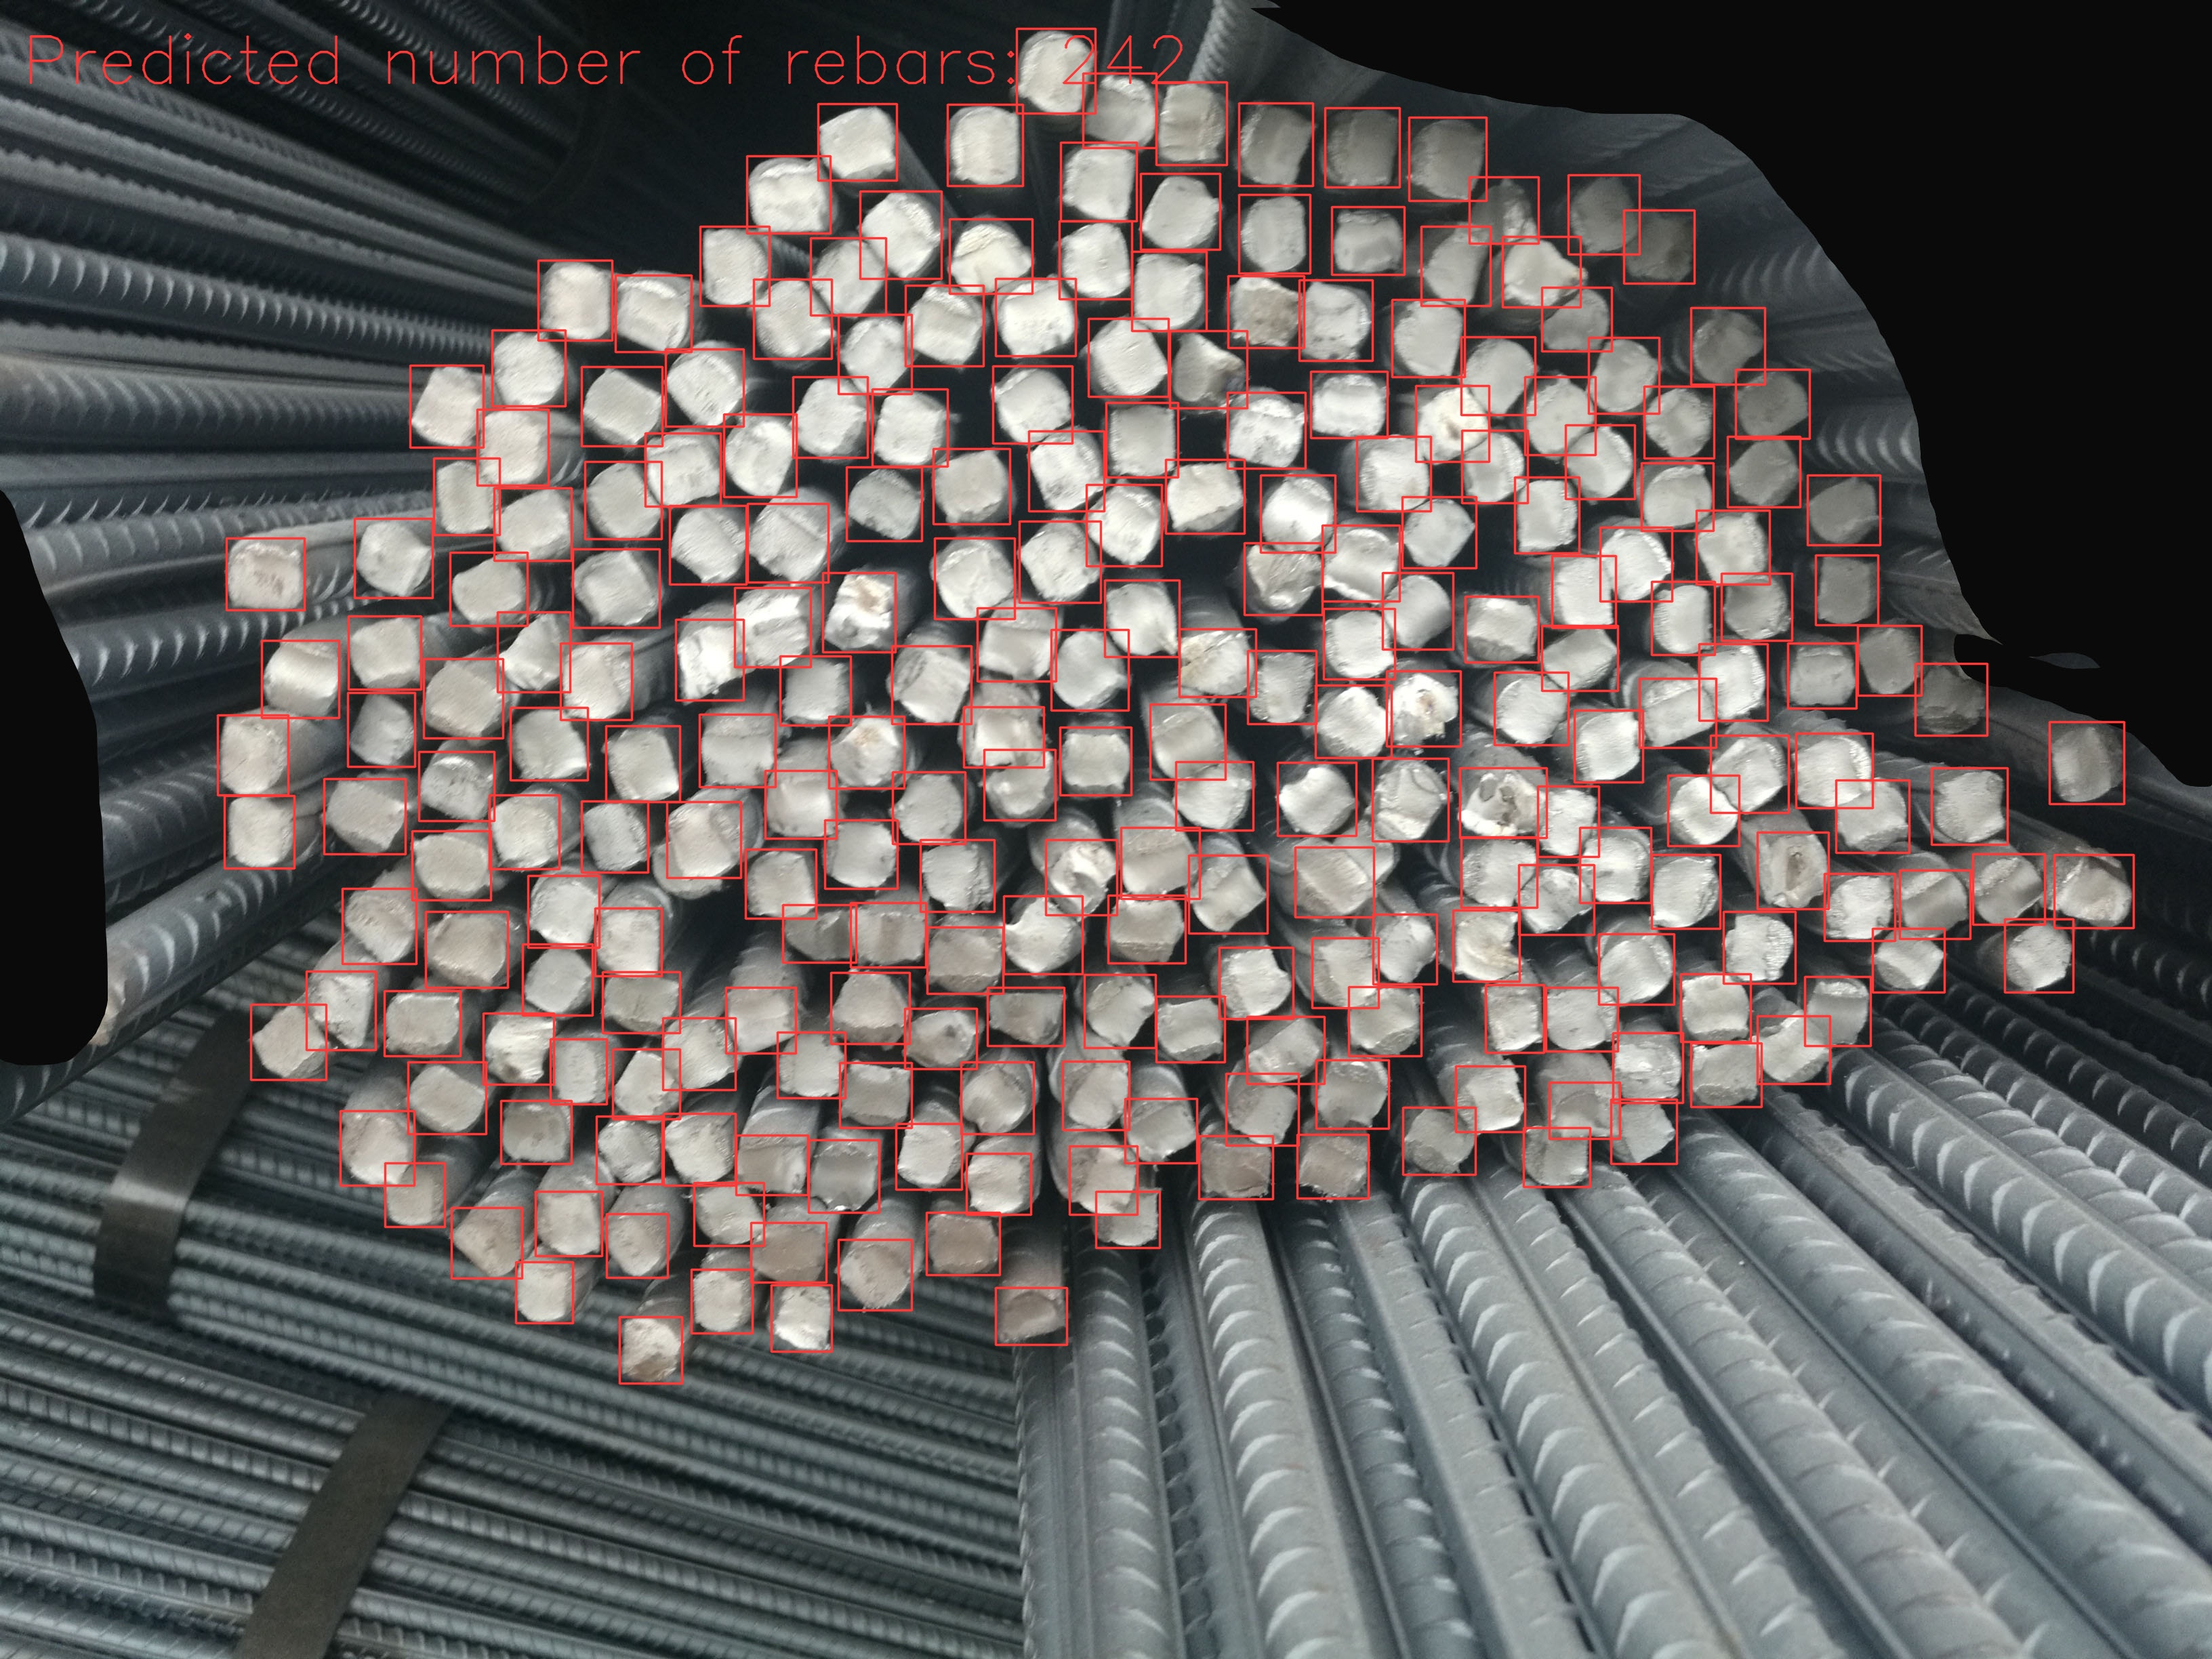

In [14]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/exp/*.jpg')[:4]:
      display(Image(filename=image_path, width=600))
      print("\n")

## 8. Conclusion

Compared to Faster R-RCNN, which was proposed in 2015, the new YOLOv9 published this week has achieved much better results in terms of prediction accuracy and inference time.

If you have any questions, please feel free to contact me at xin.yao.ict@gmail.com.